# Fine Tune GPT-2 Model

Open Questions:
- Is it useful to add \<bot> statement as preparing step? -> yesss
- Should one batch, one dialog?
- Currently the dialogs are mixed, so only question and answer is paired right now
    - How to fix?
    - The batches?
- Removing Bot answers?<br>
    From:<br>
    '<start> Create me a unique interactive story to calm with the topic: Ocean. <bot>:Ah, the ocean... <end>',<br>
    "<start> Ah, the ocean. Such a ... <end>",<br>
    "<start> Yes, I can feel it...'<br>
    <br>
    to:<br>
    '<start> Create me a unique interactive story to calm with the topic: Ocean. <bot>:Ah, the ocean... <end>',<br>
    "<start> Yes, I can feel it...'<br>


1. **Dialog-based Approach:**
   - **One Batch, One Dialog:**
     - Treat each dialog as a separate training example. This allows the model to learn the context and flow of individual conversations.
     - Helps the model focus on capturing the nuances of each conversation independently.
     - Useful if your storytelling involves short, distinct dialogs.

   - **Inclusion of the Past:**
     - You can include the past history within each dialog example. Concatenate the previous turns in the conversation to provide context.
     - This helps the model understand the context and continuity of the ongoing dialog.
     - Be mindful of the token limit, as GPT-2 has a maximum token limit, and longer sequences might get truncated.

2. **Memory and Context:**
   - GPT-2 has a limited context window due to its fixed input size. If the conversations are long, you might lose relevant information.
   - Consider balancing the length of your input sequences to ensure the model can capture essential details.

3. **Dynamic Context Window:**
   - Instead of a fixed history length, you could use a sliding window approach.
   - Maintain a dynamic context window that moves along the conversation, incorporating the most recent interactions.

4. **Experiment and Evaluate:**
   - It's often beneficial to experiment with different approaches to see what works best for your specific use case.
   - Conduct thorough evaluations using validation data to ensure the model is learning effectively and providing desired responses.

5. **Training Strategies:**
   - Experiment with hyperparameters like learning rate, batch size, and the number of training epochs to fine-tune the model effectively.
   - Monitor the model's performance on both training and validation sets.

Preprocess: handling tokenization, special tokens, and managing the context window.

Hint: Use the dialogs.txt file to train the model on google colab.

### System

In [1]:
!python --version

Python 3.10.12


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan  4 15:36:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [5]:
!cat /proc/meminfo

MemTotal:       53470760 kB
MemFree:        48359280 kB
MemAvailable:   51962376 kB
Buffers:          367224 kB
Cached:          3694284 kB
SwapCached:            0 kB
Active:           633176 kB
Inactive:        4115476 kB
Active(anon):       1008 kB
Inactive(anon):   687408 kB
Active(file):     632168 kB
Inactive(file):  3428068 kB
Unevictable:           4 kB
Mlocked:               4 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               676 kB
Writeback:             0 kB
AnonPages:        687324 kB
Mapped:           265828 kB
Shmem:              1268 kB
KReclaimable:     101076 kB
Slab:             155624 kB
SReclaimable:     101076 kB
SUnreclaim:        54548 kB
KernelStack:        6048 kB
PageTables:        15136 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26735380 kB
Committed_AS:    2674528 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       75684 kB
VmallocChunk:    

### Imports

In [6]:
#!python -m pip install torch
#!python -m pip install transformers

In [1]:
#from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from datetime import datetime as dt

import json

import transformers
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

In [2]:
os.listdir("./")

['.git',
 '.gitignore',
 'API_KEY.txt',
 'cached',
 'data',
 'data_generation.ipynb',
 'data_generation_V4.ipynb',
 'dialogs.txt',
 'dialogs_RIS_Bot.txt',
 'executed_commands.pickle',
 'executed_commands_V4.pickle',
 'final_es_conv.csv',
 'inference.ipynb',
 'information.pickle',
 'information_V4.pickle',
 'inspiration.ipynb',
 'LICENSE.txt',
 'logo.jpeg',
 'model',
 'README.md',
 'RIS_bot_data',
 'stop.exe',
 'stop.py',
 'stop.txt',
 'train_V3.ipynb',
 'train_V4.ipynb']

### Load and Prepare the data

In [11]:
MODEL_PATH = "./model/model.pth"
MODEL_WEIGHT_PATH = "./model/model_weights.pth"
ONNX_PATH = "./model/model.onnx"
MAX_LENGTH = 1024   #"auto"
# ".pt", ".pth", ".pkl", or ".h5"

class Dialog_Data(Dataset):

    def __init__(self, tokenizer, data_dir_path="./data", read_one_file=False, should_save_as_one_file=True):
        self.tokenizer = tokenizer
        self.data_dir_path = data_dir_path
        self.read_data(data_dir_path, read_one_file, should_save_as_one_file)

    def read_data(self, data_dir_path, read_one_file, should_save_as_one_file=True):
        global MAX_LENGTH

        data = []
        conversations = []
        if read_one_file:
            with open("./dialogs.txt", "r", encoding="latin1") as f:
                raw = f.read()
            for dialog in raw.split("#/"):
                cur_conversation = []
                for sentence in dialog.split(";"):
                    data += [sentence]
                    cur_conversation += [sentence]
                conversations += [(cur_conversation)]
        else:
            for dialog in os.listdir(self.data_dir_path):
                    with open(f"{self.data_dir_path}/{dialog}", "r") as f:
                        cur_conversation = []
                        for idx, line in enumerate(f.read().split("\n")):
                            content = ":".join(line.split(":")[1:]).strip()
                            if len(content) > 0:
                                data += [content]
                                cur_conversation += [content]
                    conversations += [(cur_conversation)]
            if should_save_as_one_file:
                save_data = ""
                for idx_1, dialog in enumerate(conversations):
                    if idx_1 > 0:
                        save_data += "#/"

                    for idx_2, elem in enumerate(dialog):
                        if idx_2 == 0:
                            save_data += f"{elem}"
                        else:
                            save_data += f";{elem}"
                    with open("./dialogs.txt", "w") as f:
                        f.write(save_data)

        # add markers and trim
        X = []
        y = []
        is_conversation_beginning = []
        for cur_conversation in conversations:
            for idx in range(0, len(cur_conversation)-1, 2):
                if idx == 0:
                    is_conversation_beginning += [1]
                else:
                    is_conversation_beginning += [0]
                X += [cur_conversation[idx]]
                y += [cur_conversation[idx+1]]

        self.conversations = conversations
        self.X = X
        self.y = y
        self.is_conversation_beginning = is_conversation_beginning

        # encoded_data = self.tokenizer(self.X, truncation=True, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length") # max_length=40, padding="max_length"
        # self.X_encoded = encoded_data['input_ids']
        # self.X_attention_mask = encoded_data['attention_mask']

        encoded_data = self.tokenizer(self.y, truncation=False, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length")
        self.y_encoded =  encoded_data['input_ids']
        self.y_attention_mask = encoded_data['attention_mask']

    def get_context(self, idx):
        with_context = ""
        cur_idx = idx
        while cur_idx >= 0:
            if cur_idx == idx:
                with_context += f"<bot>{self.y[cur_idx]}"  # <end>
                with_context = f"{self.X[cur_idx]}{with_context}"
            else:
                with_context = f"{self.y[cur_idx]}<sep>{with_context}"
                with_context = f"{self.X[cur_idx]}<sep>{with_context}"
            if self.is_conversation_beginning[cur_idx] == 1:
                break
            cur_idx -= 1
        #with_context = f"<start>{with_context}"
        return with_context

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.get_context(idx)
        encoded_data = self.tokenizer(X, truncation=True, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length")
        return (encoded_data['input_ids'], encoded_data['attention_mask'])#, self.y_encoded[idx])



In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({  "pad_token": "<pad>",
                                # "bos_token": "<start>",
                                # "eos_token": "<end>",
                                "sep_token": "<sep>"})
tokenizer.add_tokens(["<bot>"])

1

In [13]:
data = Dialog_Data(tokenizer=tokenizer, read_one_file=True, should_save_as_one_file=True)
data = DataLoader(data, batch_size=4, shuffle=True)

In [12]:
# check the data
[print(i, "\n") for i in data.dataset.X[:3]];

Hey, I've been feeling really down lately. I just can't seem to find any motivation or purpose in my life. 

What was the story about? 

That's really inspiring. But how did he manage to find motivation and purpose in his life? 



In [14]:
data.dataset.get_context(3)

"Hey, I've been feeling really down lately. I just can't seem to find any motivation or purpose in my life.<sep>I completely understand how you feel. I went through a similar phase a while back. I had lost all sense of direction and felt like my life lacked purpose. But then I came across this incredible story that really inspired me.<sep>What was the story about?<sep>It was about a man named Nick Vujicic. He was born without arms and legs, and faced numerous challenges and obstacles throughout his life. Despite all that, he never let his disabilities define him. Instead, he used his setbacks as fuel to achieve incredible things. He became a motivational speaker, inspiring millions of people around the world.<sep>That's really inspiring. But how did he manage to find motivation and purpose in his life?<sep>Well, Nick didn't let his circumstances determine his happiness or success. He believed that true happiness and purpose come from within, and he focused on developing a positive mind

In [15]:
data.dataset.get_context(10)

"Hey, I've been feeling really overwhelmed lately and I think I might have Separation Anxiety Disorder.<bot>Oh, I'm sorry to hear that. What exactly are you experiencing?"

In [16]:
data.dataset.get_context(203)

"Good afternoon, Doctor. Thank you for seeing me today.<sep>Good afternoon. It's my pleasure. How can I assist you?<sep>I've been feeling really overwhelmed lately. I constantly feel anxious and have trouble sleeping.<sep>I'm sorry to hear that. When did you first start noticing these symptoms?<sep>It's been going on for a few months now. It started after a major life event - a job loss and the end of a long-term relationship.<bot>Those are significant stressors indeed. How do you cope with these feelings of anxiety?"

In [16]:
len(data.dataset)

11149

In [17]:
# # Test saved dialogs in one file
# counter = 0
# with open("./dialogs.txt", "r") as f:
#     dialogs = f.read()
# print(f"Dialogs amount: {len(os.listdir('./data'))}")
# print(f"In one file dialogs amount: {len(dialogs.split('#'))}")

In [19]:
BATCH_AMOUNT = 0
for X, a, y in data:
    BATCH_AMOUNT += 1
    if BATCH_AMOUNT == 5:
        print("X:")
        print("Decoded:", tokenizer.decode(X[0][0]))
        print("Encoded:", X[0])
        print(type(X[0]))
        print(len(X[0]))
        print("AttentionMask:\n", a[0])
        print(type(a[0]))
        print(len(a[0]))
        print("Target:\nDecoded:", tokenizer.decode(y[0][0]))
        print("Encoded:", y[0])
        print(type(y[0]))
        print(len(y[0]))

BATCH_AMOUNT

### Load pretrained model

In [21]:
config = transformers.GPT2Config.from_pretrained("gpt2")
config.do_sample = config.task_specific_params['text-generation']['do_sample']
#config.max_length = MAX_LENGTH #config.task_specific_params['text-generation']['max_length']
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))
model.eval()

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50262, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50262, bias=False)
)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [23]:
model = model.to(device)

### First test

In [24]:
def inference(prompt:str, model, tokenizer, device, padding, clear_output=True):
    model.eval()
    prompt = tokenizer(prompt, return_tensors="pt", padding=padding)
    X = prompt["input_ids"].to(device)
    a = prompt["attention_mask"].to(device)
    with torch.no_grad():
        output = model.generate(X, attention_mask=a, pad_token_id=tokenizer.eos_token_id)

    if clear_output:
        output = tokenizer.decode(output[0], skip_special_tokens=True)
    else:
        output = tokenizer.decode(output[0], skip_special_tokens=False)

    if type(output) == list and len(output) == 1:
        output = output[0]
    return output

In [25]:
inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding="max_length", clear_output=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


"Hey, I'm feeling not so good.<end_user>"

In [26]:
inference(prompt="Hey, I've been feeling really down lately.", model=model, tokenizer=tokenizer, device=device, padding="max_length", clear_output=False)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


"Hey, I've been feeling really down lately.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

### Fine Tune Model

In [27]:
def print_time_information(start, end=None, total_seconds=None, text="Total training time:", should_print=True):
    if type(total_seconds) is type(None):
        if type(end) is type(None):
            end = dt.now()
        total_seconds = abs((start-end).total_seconds())

    minutes, seconds = divmod(total_seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    res = f"{text}\n    -> {int(days)} Days\n    -> {int(hours)} Hours\n    -> {int(minutes)} Minutes\n    -> {int(seconds)} Seconds"
    if should_print:
        print(res)
    return res

def calculate_train_duration(epoch_start, batch_amount, epochs, cur_epoch):
    """
    Call this function once after the first batch every epoch.
    """
    cur_epoch += 1
    now = dt.now()
    duration_one_batch = abs((epoch_start-now).total_seconds())
    duration_for_one_epoch = duration_one_batch * batch_amount
    epochs_left = (epochs - cur_epoch) + 1    # current epoch also have to run
    predicted_training_duration = epochs_left * duration_for_one_epoch
    res = f"{'-'*16}\n"
    text = f"Training will need about following time for {epochs_left} epochs:"
    res += print_time_information(start=epoch_start, total_seconds=predicted_training_duration, text=text, should_print=False)
    res += f"\n{'-'*16}"
    print(res)
    return res

In [29]:
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 6

loss_hist = []
steps = 0

solutions = []
solutions_cleared = []

start = dt.now()

with open("./log.txt", "w") as f:
    f.write(f"Log File for Training Calm Chatbot {start.strftime('%d.%m.%Y - %H:%M:%S')}")

for cur_epoch in range(0, epochs):
    model.train()
    epoch_start = dt.now()
    new_epoch = True
    for input_ids, attention_masks, labels in data:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask=attention_masks, labels=labels).loss
        loss_hist += [loss.item()]
        loss.backward()
        optimizer.step()
        steps += 1

        if new_epoch:
            time_prediction = calculate_train_duration(epoch_start, BATCH_AMOUNT, epochs, cur_epoch)
            new_epoch = False

            with open("./log.txt", "a") as f:
                f.write(f"\n\n{time_prediction}")

    torch.save(model.state_dict(), f"./model_state_V4_{cur_epoch}.pt")
    epoch_info = f'Epoch {cur_epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Steps: {steps}, Current Time:{dt.now().strftime("%H:%M:%S")}'
    print(epoch_info)
    test_prompt = inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=False)
    solutions += [test_prompt]
    solutions_cleared += [inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=True)]

    with open("./log.txt", "a") as f:
        f.write(f"\n\n{epoch_info}\n\nTest-Prompt:\n{test_prompt}")

    # allocate memory
    #gc.collect()
    # if device.type == "cuda":
    #     torch.cuda.empty_cache()

----------------
Training will need about following time for 6 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
    -> 0 Seconds
----------------
Epoch 1/6, Training Loss: 0.2210, Steps: 2788, Current Time:16:04:27


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


----------------
Training will need about following time for 5 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
    -> 0 Seconds
----------------
Epoch 2/6, Training Loss: 0.2133, Steps: 5576, Current Time:16:23:16
----------------
Training will need about following time for 4 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
    -> 0 Seconds
----------------
Epoch 3/6, Training Loss: 0.2321, Steps: 8364, Current Time:16:42:04
----------------
Training will need about following time for 3 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
    -> 0 Seconds
----------------
Epoch 4/6, Training Loss: 0.1618, Steps: 11152, Current Time:17:00:53
----------------
Training will need about following time for 2 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
    -> 0 Seconds
----------------
Epoch 5/6, Training Loss: 0.3035, Steps: 13940, Current Time:17:19:43
----------------
Training will need about following time for 1 epochs:
    -> 0 Days
    -> 0 Hours
    -> 0 Minutes
 

Total training time:
    -> 0 Days
    -> 1 Hours
    -> 52 Minutes
    -> 53 Seconds


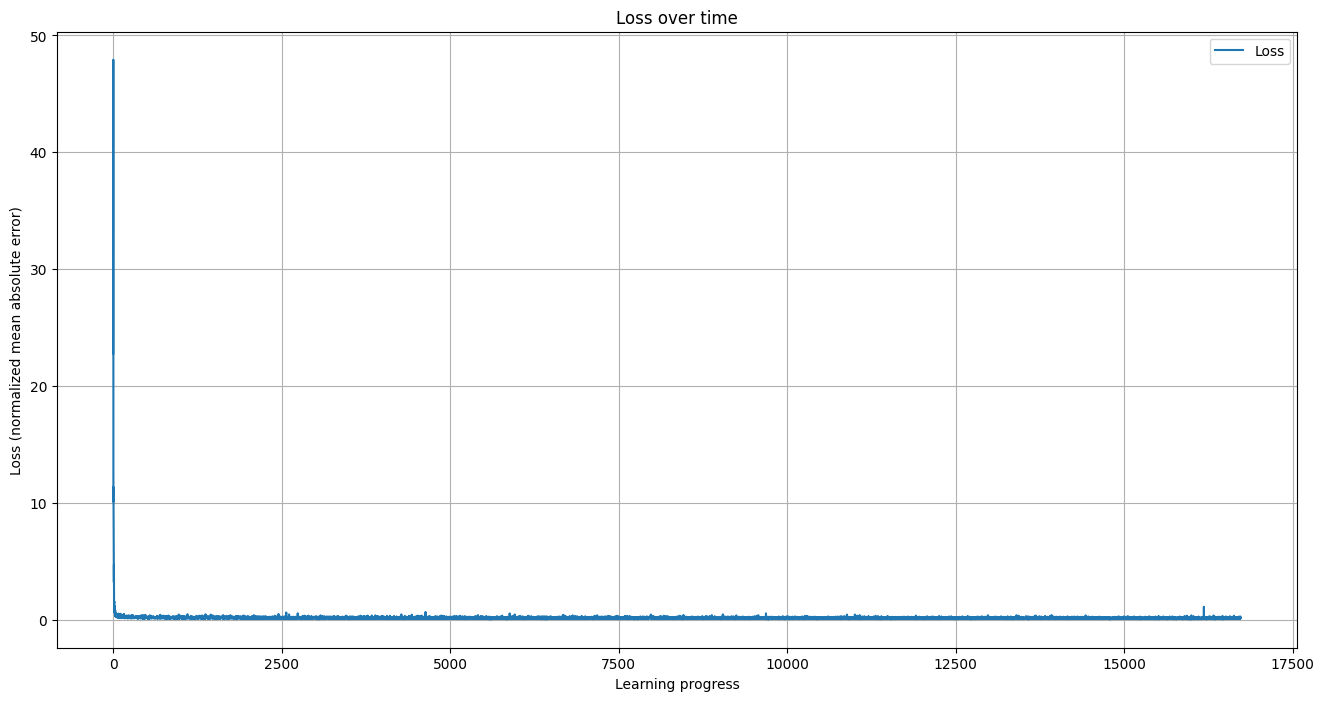

In [30]:
print_time_information(start)

# plot loss
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(len(loss_hist)-1), loss_hist[1], label='Loss')
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()

# save step solution-predictions:
with open("./result_per_epoch.txt", "w") as f:
    res = ""
    for i, cur_res in enumerate(solutions, start=1):
        res += f"\n{'-'*16}\n{i:02d}. Epoch:\n{cur_res}"
    f.write(res)

In [37]:
import pickle

with open('./loss_hist.pkl', 'wb') as f:
    pickle.dump(loss_hist, f)

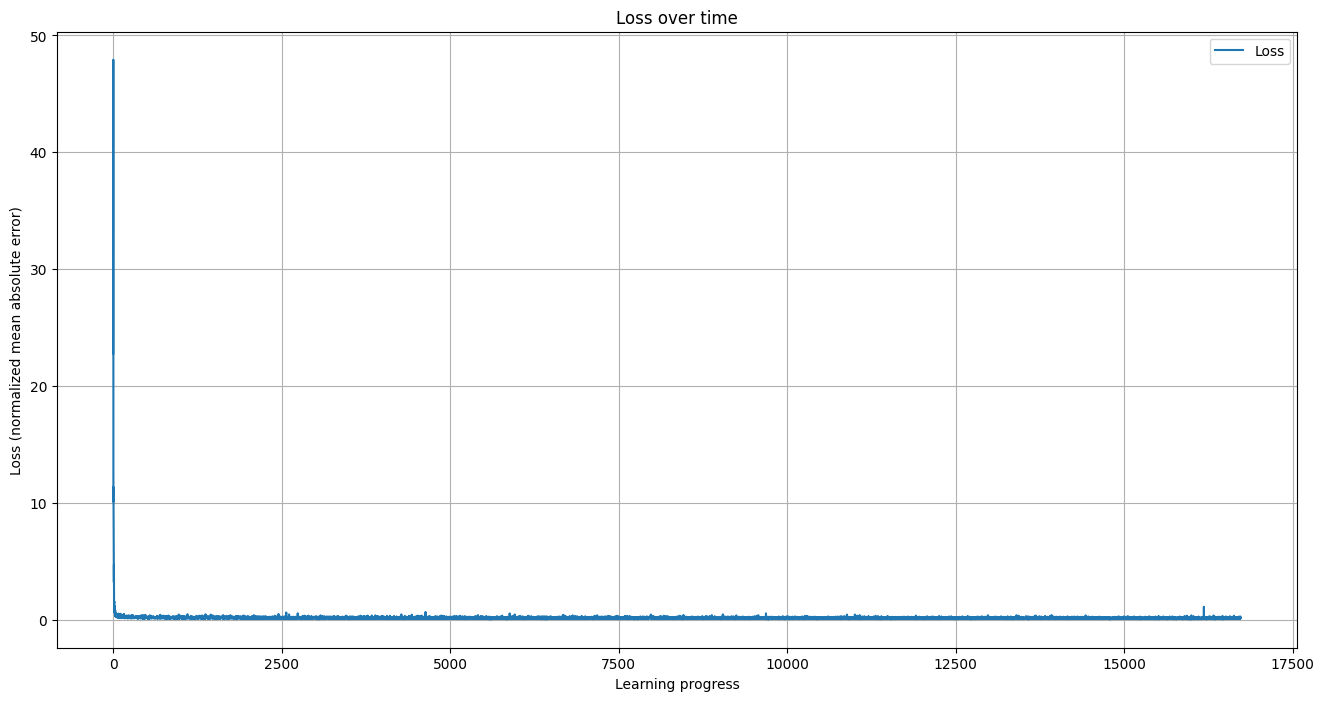

In [52]:
# plot loss
OFFSET = 0
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(len(loss_hist)-OFFSET), loss_hist[OFFSET:], label='Loss')
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()

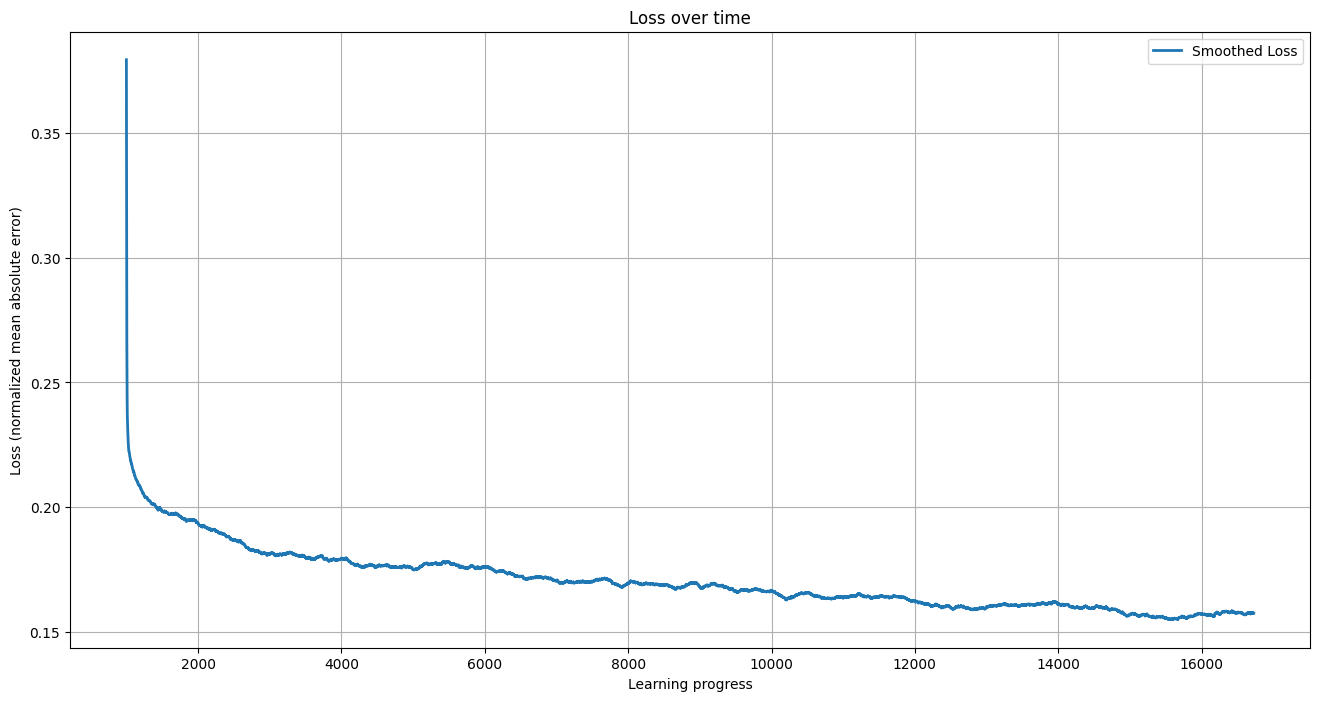

In [53]:
import matplotlib.ticker as mticker

OFFSET = 0
loss_series = pd.Series(loss_hist[OFFSET:])

# Wenden Sie das gleitende Fenster an
window_size = 1000  # Größe des gleitenden Fensters
loss_rolling = loss_series.rolling(window=window_size).mean()

# Zeichnen Sie die ursprünglichen und geglätteten Daten
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#ax.plot(np.arange(len(loss_hist)), loss_hist, label='Original Loss')
ax.plot(np.arange(len(loss_series.index)), loss_rolling, label='Smoothed Loss', linewidth=2)
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()
# formatter = mticker.ScalarFormatter()
# formatter.set_scientific(False)
# ax.yaxis.set_major_formatter(formatter)
# ax.set_yscale('log')

plt.savefig("./loss.png")
plt.show()


### Save model

-> Propably save the model in a extra repository/branch and provide it as python module<br>
-> Is model very big?

save only weights

In [31]:
torch.save(model.state_dict(), MODEL_WEIGHT_PATH)

# loading
# config = transformers.GPT2Config.from_pretrained("gpt2")
# config.max_length = MAX_LENGTH #config.task_specific_params['text-generation']['max_length']
# model = transformers.GPT2LMHeadModel.from_pretrained("gpt2", config=config)
# model.resize_token_embeddings(len(tokenizer))
# model.load_state_dict(torch.load(MODEL_WEIGHT_PATH))
# model.eval()

save whole model

In [32]:
torch.save(model, MODEL_PATH)

# loading
# model = torch.load(MODEL_PATH)
# model.eval()

save in Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = "/content/gdrive/My Drive/model.pt"
# torch.save(model.state_dict(), path)

---
### Ressources:

- https://www.toolify.ai/ai-news/finetuning-gpt2-for-conversational-chatbots-10476
- https://huggingface.co/docs/transformers/model_doc/gpt2
- [PyTorch kompakt](https://www.thalia.de/shop/home/artikeldetails/A1062166688)
- https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
- https://github.com/itsuncheng/fine-tuning-GPT2/tree/master
- https://www.kaggle.com/code/pinooxd/gpt2-chatbot/notebook

<br>

---